In [1]:
DEBUG = True
CONFIG_FILE = f'/datascope/subaru/data/targeting/CO/test/netflow/test_002/ga-netflow_20250117200108.config'
OUTPUT_PATH = f'/datascope/subaru/data/targeting/CO/test/netflow/test_002'

# Plot the target lists

Load the target lists and plot them.

In [2]:
import os, sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rc('font', size=6) #controls default text size

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [6]:
import pfs.utils

from pfs.ga.targeting.config import NetflowConfig
from pfs.ga.targeting.io import ObservationSerializer
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection, Pointing
from pfs.ga.targeting.scripts.netflowscript import NetflowScript

# Load the netflow config file

In [7]:
# Load the configuration
config = NetflowConfig.default()
config.load(CONFIG_FILE, ignore_collisions=True, format='.json')

print(config.targets.keys())

2025-01-17T18:19:50.290 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-17T18:19:50.327 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-17T18:19:50.334 20 cobraCoach cc connecting to fpga....
2025-01-17T18:19:50.337 30 butler     newRun: /tmp/cobra_coach/20250117_074


dict_keys(['targets', 'sky', 'fluxstd'])


# Load the target lists

In [8]:
target_lists = {}

for key in config.targets:
    fn = os.path.join(OUTPUT_PATH, f'{config.field.key}_targets_{key}.feather')
    reader = ObservationSerializer(catalog_name=key)
    target_lists[key] = reader.read(fn)
    print(key, config.targets[key].prefix, config.targets[key].path)

targets sci $PFS_TARGETING_DATA/data/targeting/CO/cosmology_region3_3h_targets.ecsv
sky sky $PFS_TARGETING_DATA/data/targeting/CO/sky_region3_3h_targets.ecsv
fluxstd cal $PFS_TARGETING_DATA/data/targeting/CO/star_region3_3h_targets.ecsv


In [9]:
# List available photometry for each target list
for k, target_list in target_lists.items():
    print(k)
    for p in target_list.photometry:
        print(' ', p)
        for m in target_list.photometry[p].magnitudes:
            print('    ', m)

targets
sky
fluxstd


# Plot target lists

In [27]:
pfi = SubaruPFI(instrument_options=config.instrument_options)

def plot_coordinates(ax, target_list, pointing, **kwargs):
    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)

    ax.autoscale(False)
    l = fov.plot_catalog(ax, target_list, size=1, scalex=False, scaley=False, **kwargs)

    ax.autoscale(True)
    pfi.plot_focal_plane(ax, fov, corners=True, projection=wfc, color='red')

    ax.set_title(target_list.name)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True)

    return l

def plot_cmd(ax, target_list, photometry, m1, m2, **kwargs):
    cmd = CMD([ColorAxis(Color([m1, m2])), MagnitudeAxis(m2)])
    
    l = cmd.plot_catalog(ax, target_list, size=1, **kwargs)

    ax.set_title(photometry.name)
    ax.grid(True)

    return l

def plot_target_list(target_list, pointing, title):
    cmap = plt.get_cmap('tab10')
    f, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=240)

    # Color by priority, if available
    if 'priority' in target_list.data:
        color = target_list.data['priority']
    else:
        color = 'black'

    l = plot_coordinates(axs[0], target_list, pointing, c=color, cmap=cmap)

    # Plot a color-magnitude diagram using the first two filters of the first photometric
    # system available in the target list that has at least two filters defined in the data set
    for p, photometry in target_list.photometry.items():
        if len(photometry.magnitudes) > 1:
            mm = list(photometry.magnitudes.keys())
            m1, m2 = mm[0], mm[1]
            plot_cmd(axs[1], target_list, photometry, photometry.magnitudes[m1], photometry.magnitudes[m2], c=color, cmap=cmap)

            break

    f.colorbar(l, ax=axs[1], orientation='vertical', label='Priority')
    f.suptitle(title)

2025-01-17T19:08:49.936 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-17T19:08:49.994 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-17T19:08:50.002 20 cobraCoach cc connecting to fpga....
2025-01-17T19:08:50.008 30 butler     newRun: /tmp/cobra_coach/20250117_077


/home/dobos/project/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  


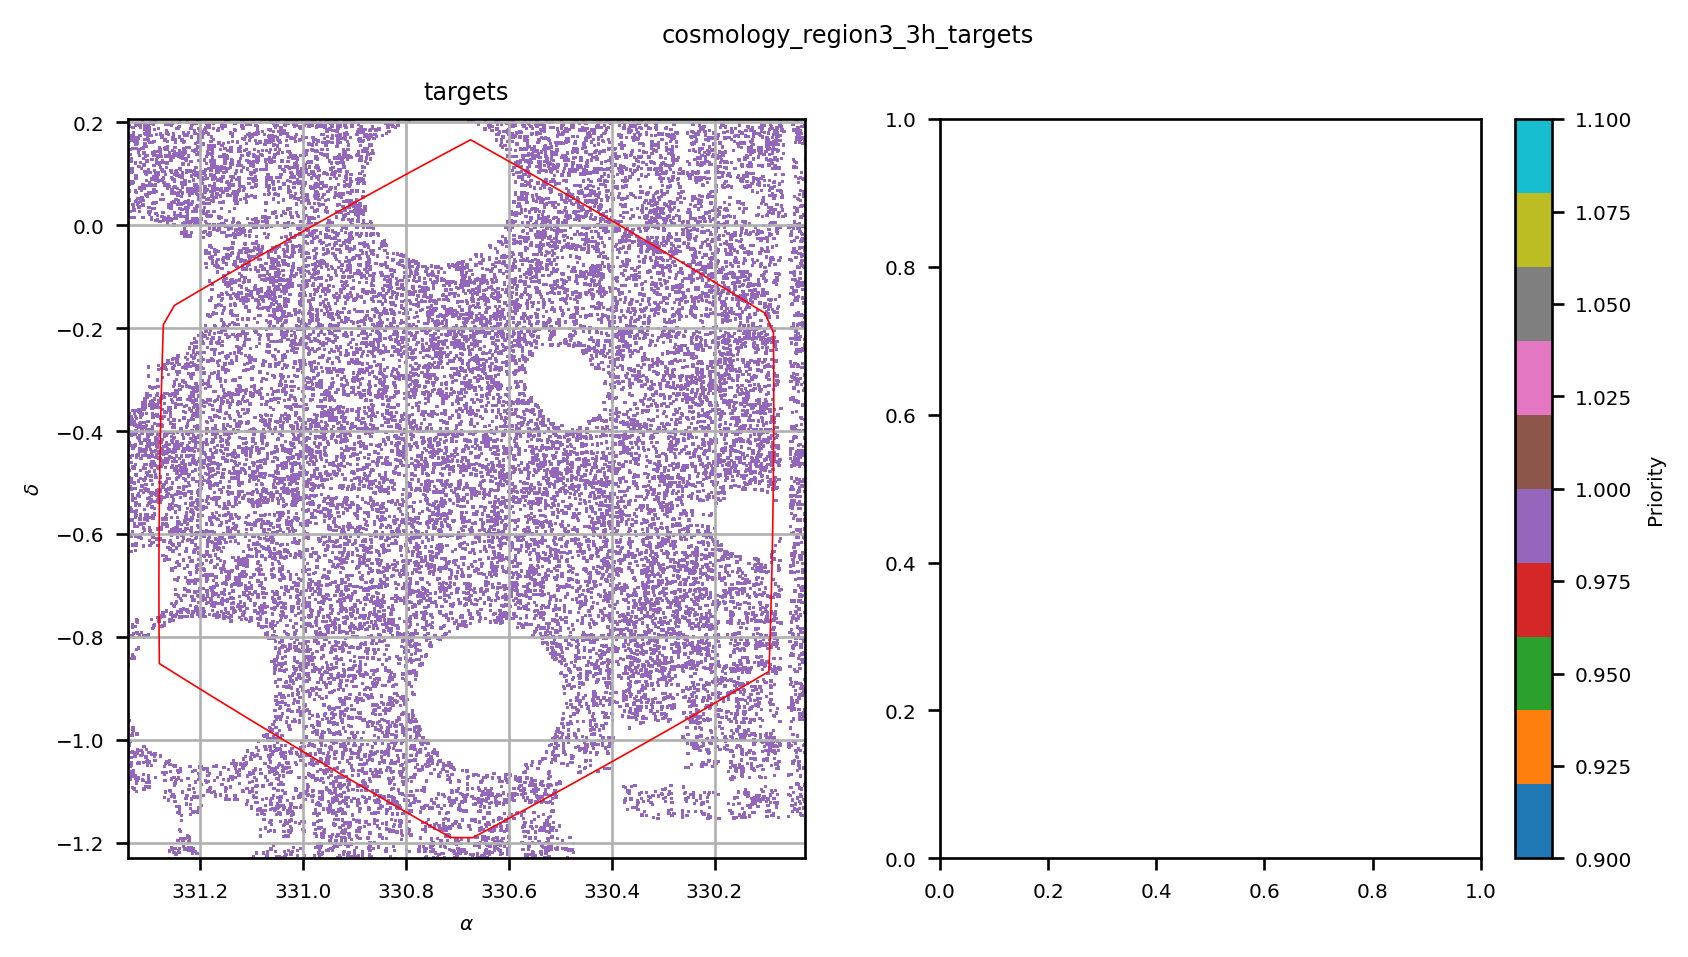

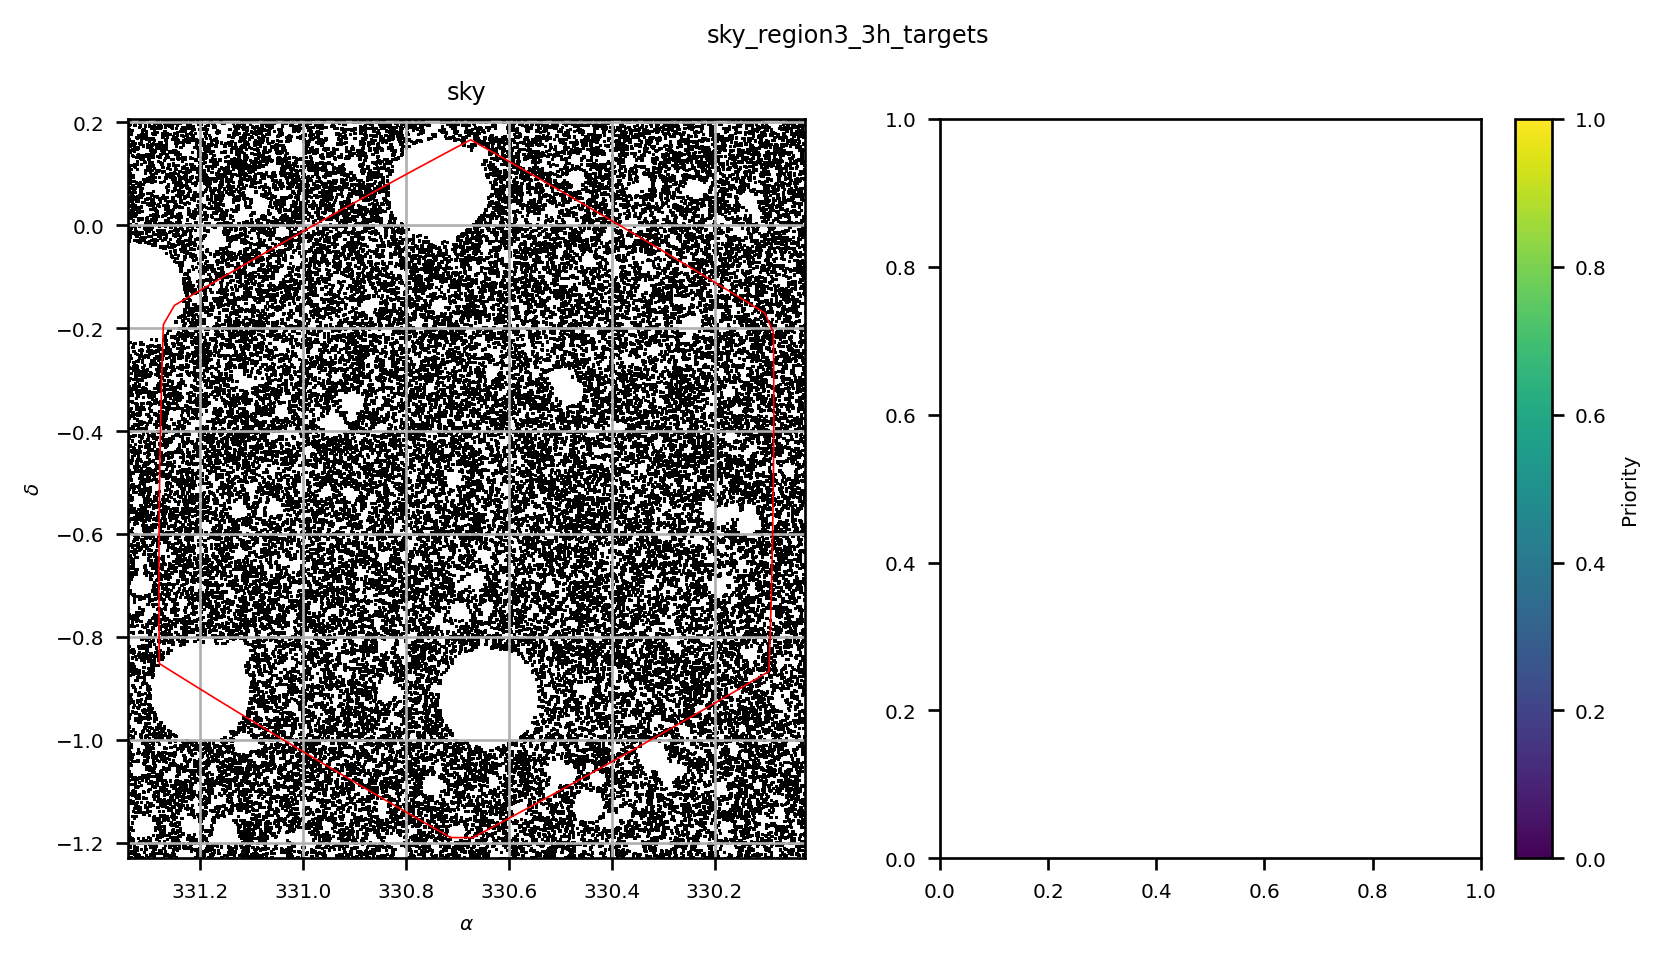

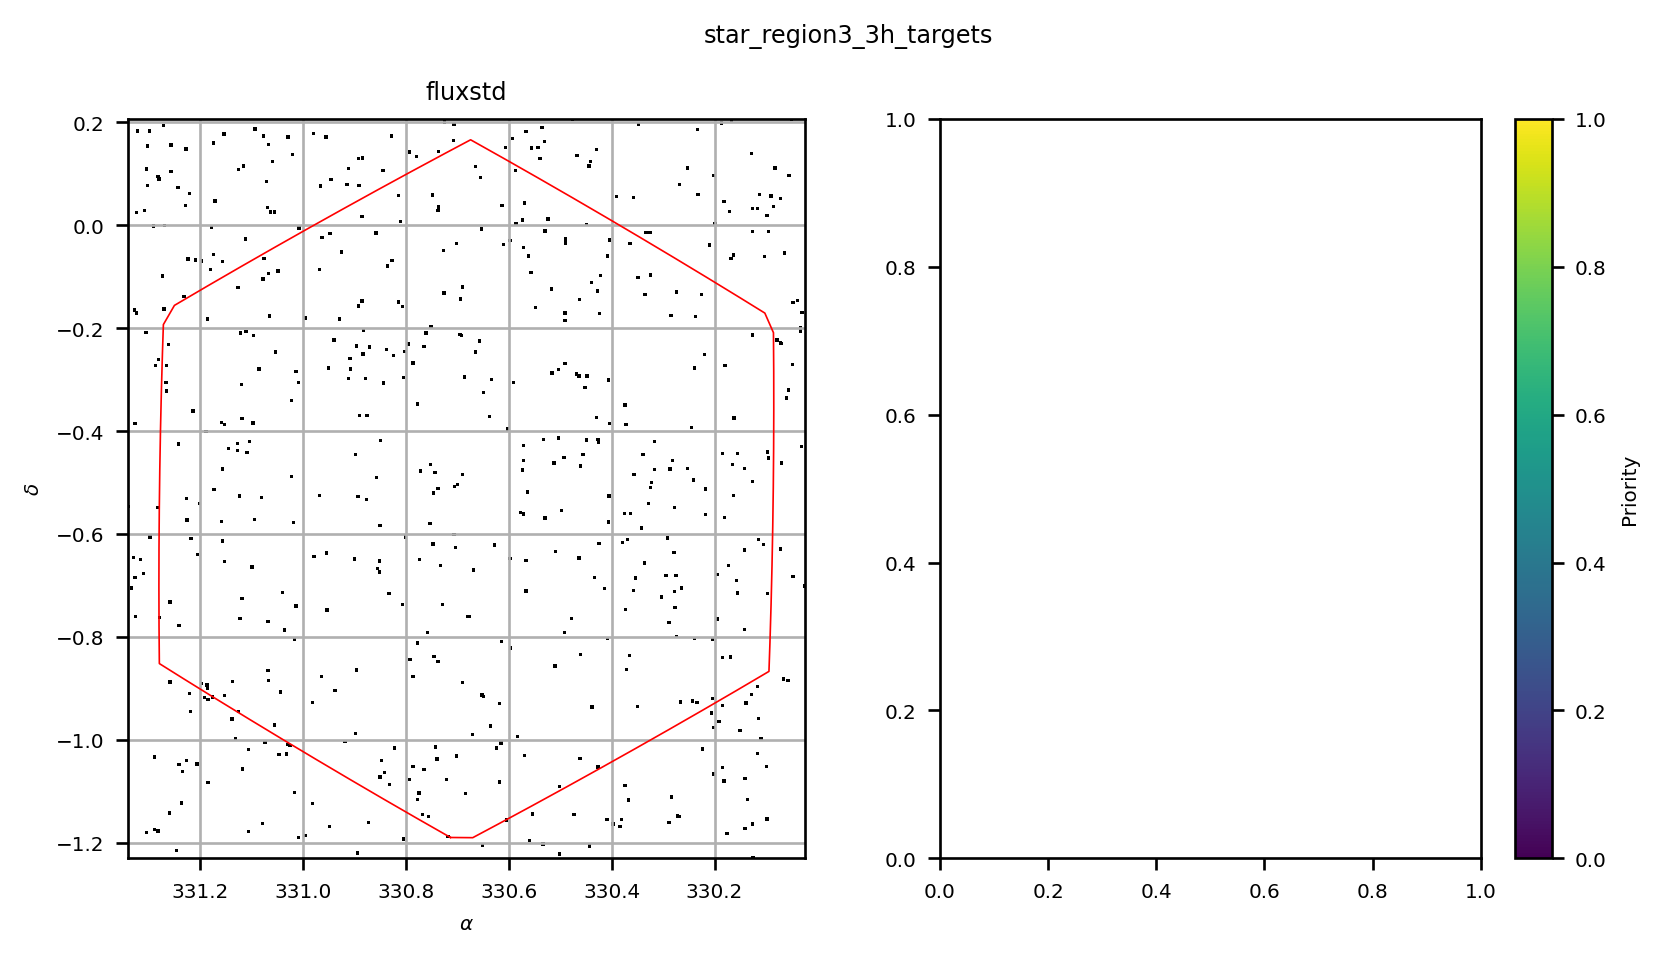

In [28]:
pointing = config.pointings[0].get_pointing()

for k in target_lists:
    _, filename = os.path.split(config.targets[k].path)
    title, _ = os.path.splitext(filename)
    plot_target_list(target_lists[k], pointing, title)

# Plot magnitude distributions

In [12]:
# Plot the magnitude distribution

for k, target_list in target_lists.items():
    if target_list.photometry is not None:
        for _, p in target_list.photometry.items():
            for _, m in p.magnitudes.items():
                f, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=240)
    
                mag, mag_err = target_list.get_magnitude(m)
                mask = np.isfinite(mag)

                hist, bins = np.histogram(mag[mask], bins=30)

                ax.plot(bins[:-1], hist)
                
                ax.set_xlabel(f'{p.name} {m.filter} magnitude')
                ax.set_ylabel('Number of targets')
                
                _, filename = os.path.split(config.targets[k].path)
                title, _ = os.path.splitext(filename)
                f.suptitle(f'{title}')

# Plot parameter distributions

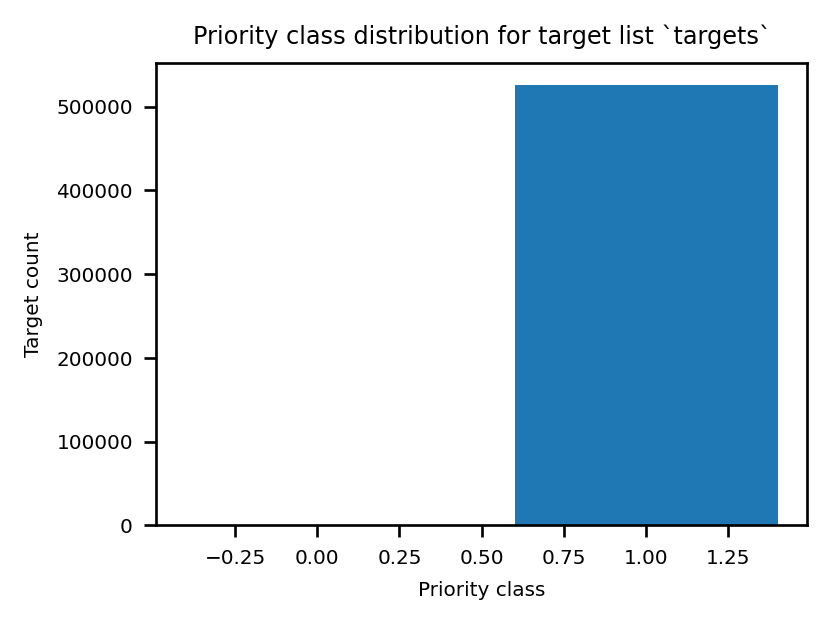

In [13]:
# Plot priority distribution for each target list
for k in config.targets:
    if config.targets[k].prefix in ['sci']:
        f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

        hist = np.bincount(target_lists[k].data['priority'])
        ax.bar(np.arange(hist.size), hist)

        ax.set_title(f'Priority class distribution for target list `{k}`')
        ax.set_xlabel(f'Priority class')
        ax.set_ylabel(f'Target count')

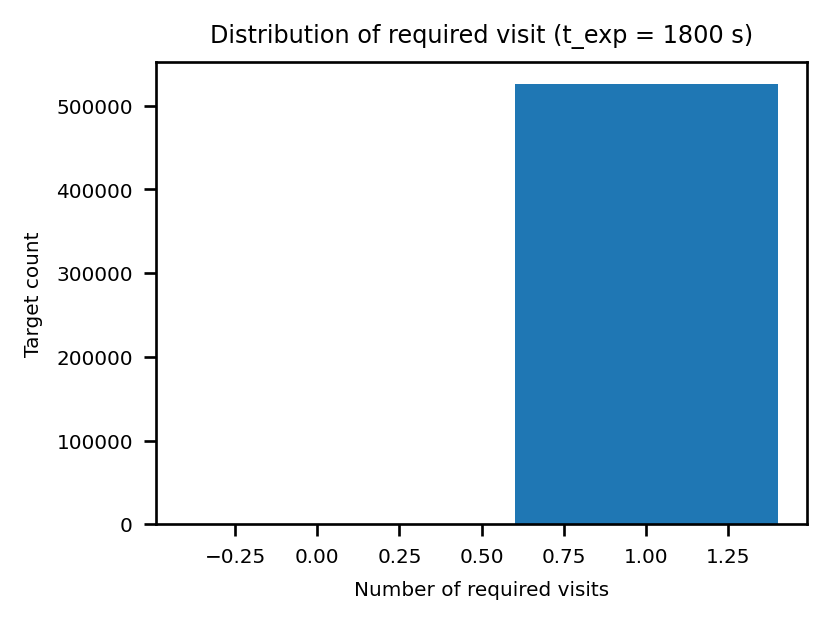

In [14]:
# Plot the distribution of required visits for each target list
exp_time = 1800 # seconds

for k in config.targets:
    if config.targets[k].prefix in ['sci']:
        f, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=240)

        hist = np.bincount((np.ceil(target_lists[k].data['exp_time'] / exp_time)).astype(int))
        ax.bar(np.arange(hist.size), hist)

        ax.set_title(f'Distribution of required visit (t_exp = {exp_time} s)')
        ax.set_xlabel('Number of required visits')
        ax.set_ylabel('Target count')
